In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier , plot_importance
import shap

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix


In [4]:
models_dir = 'models/'
data_dir = 'data/'

In [5]:
ids_test = pd.read_pickle(data_dir + 'ids_test.pkl')
y_test = pd.read_pickle(data_dir +'y_test.pkl')
X_test = pd.read_pickle(data_dir +'X_test.pkl')

X_val = pd.read_pickle(data_dir +'X_val.pkl')

### Performance del Modelo V0 

In [6]:
model_name = 'model_hip_opt_v0'
model_format_file = ".json"

In [7]:
model = XGBClassifier()
model.load_model(models_dir+model_name+model_format_file)

predictions = model.predict_proba(X=X_test)[:,1]

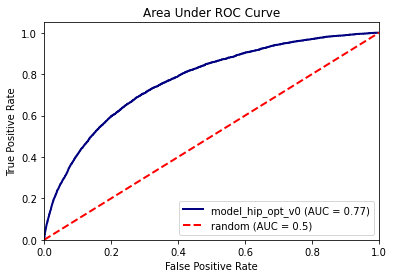

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="navy",
    lw=lw,
    label=f"{model_name} (AUC = {round(roc_auc, 2)})" ,
)
plt.plot([0, 1], [0, 1], color="red", lw=lw, linestyle="--", label = "random (AUC = 0.5)" )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under ROC Curve")
plt.legend(loc="lower right")
plt.show()

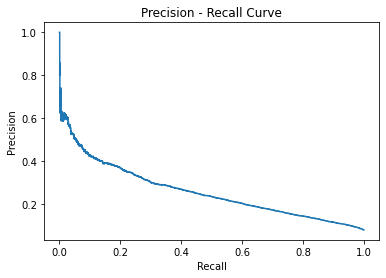

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot() 
plt.title("Precision - Recall Curve")
plt.show()

#### Definición de umbral
A partir de un valor mínimo para la métrica de Recall o Precision

In [50]:
def set_thresholds_precision_recall(y_true,y_pred,metric='recall', min_recall=None, min_precision=None):
    metrics = {}
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    if metric == 'recall':
        operating_point_idx = np.argmin(recall>=min_recall)
    elif metric == 'precision':
        operating_point_idx = np.argmax(precision>=min_precision)
    
    metrics['Threshold'] = thresholds[operating_point_idx]
    metrics['Precision'] = precision[operating_point_idx]
    metrics['Recall'] = recall[operating_point_idx]
    
    y_pred_label = np.where(y_pred >= metrics['Threshold'], 1, 0)
    accu = accuracy_score(y_true, y_pred_label)
    
    metrics['Accuracy'] = accu

    
    return metrics, y_pred_label

In [54]:
metric = 'recall'
m_recall = 0.6

In [55]:
performance_metrics , y_pred_dummy = set_thresholds_precision_recall(y_test, predictions, metric=metric, min_recall = m_recall)

In [56]:
performance_metrics

{'Threshold': 0.103312396,
 'Precision': 0.20382646639254845,
 'Recall': 0.5999012101753519,
 'Accuracy': 0.7810800157666535}

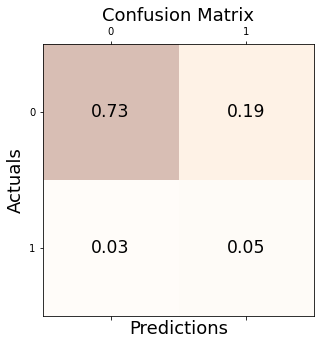

In [63]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_dummy, normalize='all')
#
# Print the confusion matrix
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s= "%0.2f" % conf_matrix[i, j], va='center', ha='center', size = 'xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Interpretabilidad del modelo

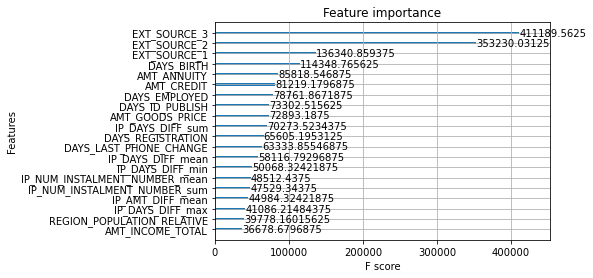

In [14]:
imp_type =  'total_gain'
xgb_fea_imp=pd.DataFrame(list(model.get_booster().get_score( importance_type=imp_type).items()),
columns=['feature','importance']).sort_values('importance', ascending=False)


plot_importance(model, importance_type=imp_type,max_num_features= 20)
plt.show()

In [15]:
background_train = shap.maskers.Independent(X_val, max_samples=500)

explainer = shap.Explainer(model, background_train)

In [16]:
shap_values = explainer(X_val[:1000])

100%|===================| 999/1000 [46:21<00:02]        

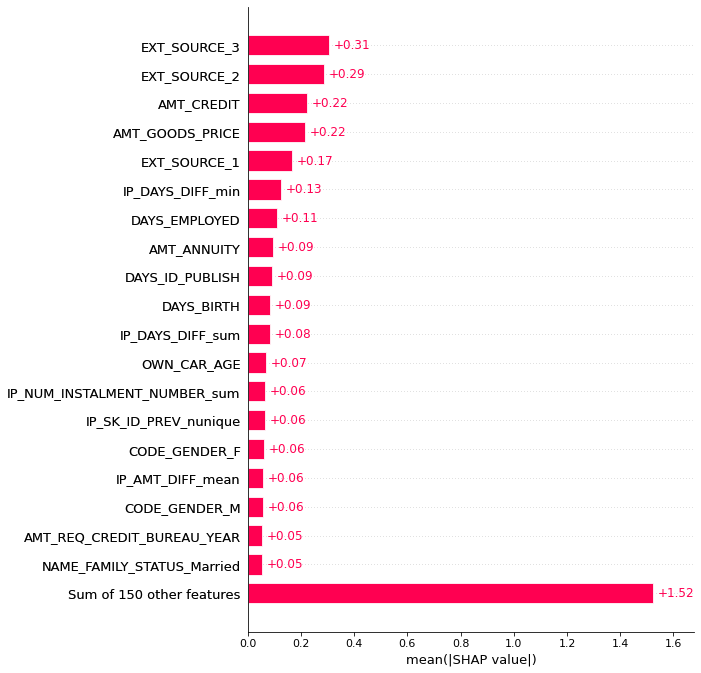

In [23]:
fig = plt.figure()
fig.patch.set_facecolor('white')
shap.plots.bar(shap_values, max_display = 20)

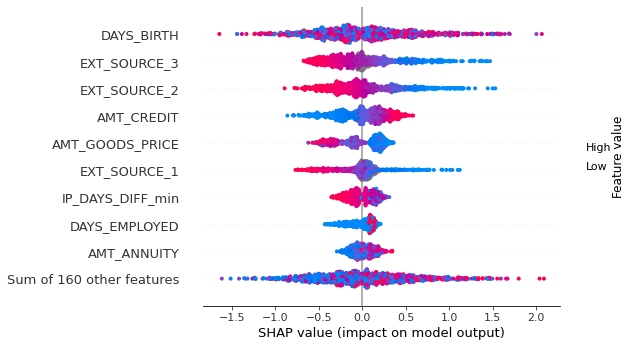

In [25]:
fig = plt.figure()
fig.patch.set_facecolor('white')
shap.plots.beeswarm(shap_values)

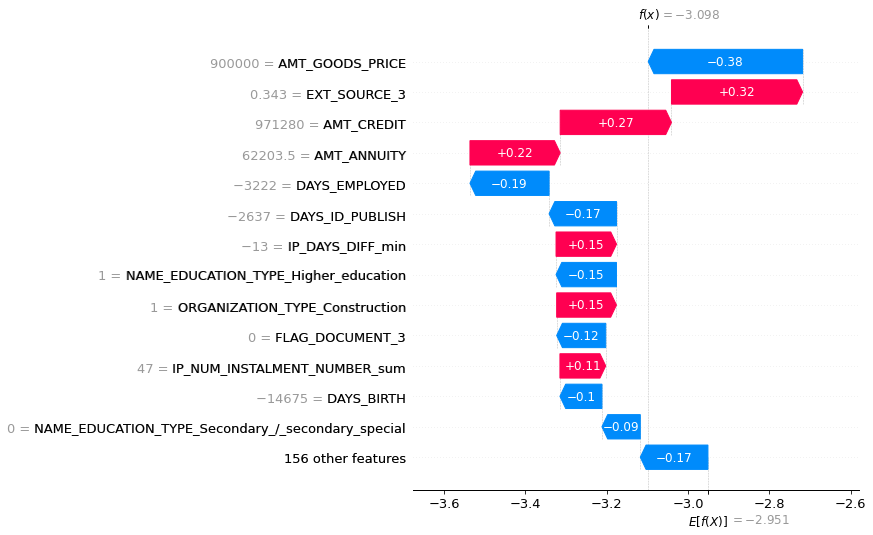

In [40]:
fig = plt.figure()
fig.patch.set_facecolor('white')
shap.plots.waterfall(shap_values[5], max_display=14)